# Numerics project option 1
Andrew Brettin  
27 April 2021

Write a solver for the heat equation $u_t = u_{xx}$, $u(x,0) = u_0(x)$, with $u_0(x)$ supported on $[a,b]$ using the central difference approximation and Crank-Nicolson timestepping.

For a boundary condition, use the Neumann-to-Dirichlet map:
$$
u(b,t) = -\frac{1}{\pi} \int_0^t \frac{u_x(b,\tau)}{\sqrt{t - \tau}} d\tau
$$
and
$$
u(a,t) = \frac{1}{\pi} \int_0^t \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau
$$

Implementation:
1. Integrate these boundary conditions as a Robin condition for the new timestep
2. Design a quadrature rule for the integrals. You can compute the integral for a constant approximation of $u_x(a, \tau)$ at each timestep.

Evaluation:
1. Test your code on a narrow gaussian initial data $\exp{\frac{-(x - 0.5)^2}{4t_0}}$. With $t_0$ sufficiently small, the data has vanished to machine precision at 0 and 1.
2. Test convergence against the true solution.

**Exact solution to IVP:**
The solution to the IVP with homogeneous Dirichlet boundary conditions given in the problem statement is incorrect. By separation by variables, we can find the true solution to the heat equation with Dirichlet boundary conditions $u(0,t) = u(1,t) = 0$:

$$
u(x,t) = \sum_{n=1}^\infty b_n \sin{(n \pi x)} e^{-(n\pi)^2t}
$$

where $b_n = 2 \int_0^1 u_0(x) \sin{(n \pi x)} dx$.  

<!-- Because these modes are odd about $x=1/2$ for $n > 1$, $b_n = 0$ for $n > 1$. Therefore, the true solution is
$$
u(x,t) = 2 \left(\int_0^1 u_0(x) \sin{(\pi x)} dx \right) \sin{(\pi x)} e^{-\pi^2t}
$$

For $n=1$, we use numpy's numerical quadrature to obtain an estimate for the true solution, as we cannot explicitly evaluate $b_1$ in closed form. -->

To compute this solution for evaluating our numerical scheme, we cannot sum up an infinite number of modes; however, we can ignore any modes such that $e^{-(n\pi)^2 t} < \epsilon$ for $t > \Delta t$, where $\epsilon$ is machine precision. In this case, modes with $n > \pi \sqrt{\frac{1}{\Delta t} \log {\frac{1}{\epsilon}}}$ become less than machine precision in $u(x,t)$ for any $t \in \{t_1, \dots, t_n\}$, so we have an estimate for the true solution exact to machine precision. Another challenge is that the integral for $b_n$ cannot be evaluated with closed form. Therefore, we use scipy's numerical quadrature to evaluate this integral, although we will build our own quadrature rule to implement the Neumann-to-Dirichlet map. This seems justifiable, as we are just using it to test convergence for our function.

In [1]:
import numpy as np
from numpy import array, arange, linspace, logspace, zeros, ones, append
from numpy import pi, e, exp, cos, sin, log, sqrt
from numpy.linalg import solve
eps = np.finfo(float).eps

from scipy.integrate import quad
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import HTML

In [11]:
# Initialize boundary condition functions
ux_a = lambda t : sin(t)
ux_b = lambda t : 1.
t0 = -1/(16*log(np.finfo(float).eps))
u0 = lambda x : exp(-(x - 1/2)**2/(4*t0))

# u_true = lambda x, t : 1/(2 * sqrt(pi * (t0 + t))) * exp(-(x - 1/2)**2/(4*(t+t0)))
term = lambda x : u0(x) * sin(pi* x)
# u_true = lambda x, t : 2 * np.sum([quad(lambda x : u0(x) * sin(pi*x), 0, 1)[0] 
#                                    * sin(n*pi * x) * exp(-pi**2 * t) for n in range(100)])
# u_true_vectorized = np.vectorize(u_true, excluded=['t'])

In [12]:
# Grid setup
a = 0
b = 1
m = 99     # Number of interior gridpoints
dx = (b - a)/(m + 1)

T = 1
dt = dx
N = int(T/dt)
r = 0.5 * dt / dx**2

xs = linspace(a, b, m+2)
ts = arange(0, T, dt)
u = xr.DataArray(np.zeros((m+2, N)), dims=('x', 't'),
                coords={'x': xs, 't':ts})
u[{'t':0}] = u0(xs)

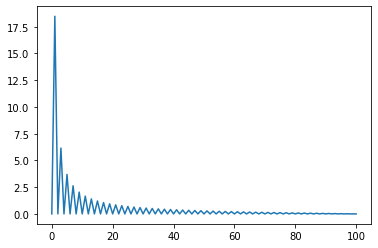

In [13]:
plt.plot(u_true_vectorized(xs, 0))

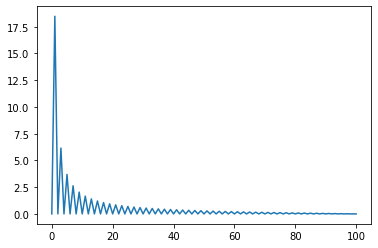

In [14]:
ys = [u_true(x,0) for x in xs]
plt.plot(ys)

## Part 1: Quadrature rule for integrals

## Part 2: Integrate boundary conditions

In [7]:
# Example boundary conditions for testing, assuming part 1 is complete
u_a = lambda t : 0
u_b = lambda t : 0

A1 = np.diag((1 + 2*r)*ones(m), 0) + np.diag(-r*ones(m-1), 1) + np.diag(-r*ones(m-1), -1)
A2 = np.diag((1 - 2*r)*ones(m), 0) + np.diag(r*ones(m-1), 1) + np.diag(r*ones(m-1), -1)

In [8]:
# Iterate and compute values
for j in range(0, N-1):
    u_last = np.array(u.isel(t=j))[1:-1] # Interior last values
    b = A2 @ u_last
    b[0] = b[0] + r * (u_a(ts[j]) + u_a(ts[j+1]))
    b[m-1] = b[m-1] + r * (u_b(ts[j]) + u_b(ts[j+1]))
    u_next = solve(A1, b)
    u[:,j+1] = [u_a(ts[j+1]), *u_next, u_b(ts[j+1])]

## Plotting and Animation

ValueError: x and y must have same first dimension, but have shapes (1001,) and (1,)

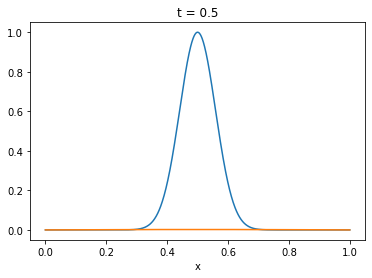

In [9]:
fig, ax = plt.subplots()
u.isel(t=0).plot(ax=ax, label='Initial value')
j=500
u.isel(t=j).plot(ax=ax, label='Numerical sol, t={}'.format(ts[j]))
ax.plot(xs, u_true(xs, t=ts[j]), label='True sol, t={}'.format(ts[j]))
ax.legend()

MovieWriter PillowWriter unavailable; trying to use pillow instead.


TypeError: 'str' object is not callable

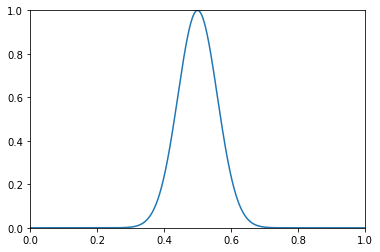

In [284]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set(xlim=(0,1), ylim=(0,1))

# line = u.isel(t=0).plot(ax=ax)[0]
line = ax.plot(xs, u.isel(t=0).data)[0]

def animate(j):
    line.set_ydata(u.isel(t=j).data)
    return line

anim = FuncAnimation(fig, animate, init_func=init, interval=10, frames=len(ts)-1, repeat=False)
anim.save('filename.gif', writer='PillowWriter')
plt.draw()
plt.show()

## Evaluation